In [1]:
from npng import PlaceHolder, Matmul, input_scale_factors, input_means, input_stds
from util import softmax, cross_entropy
from common import *

import numpy as np
import nngen as ng

# Global buffer上のアドレスを直接埋め込み
l0 = PlaceHolder(784, input_layer_name, 64)
l1 = Matmul(l0, 784, 100, "l1", 91840)
l2 = Matmul(l1, 100, 100, "l2", 91968)
l3 = Matmul(l2, 100, 10, output_layer_name, 0, False)
layers = [l1, l2, l3]

ng.to_veriloggen([l3.out_ng], "mlp", config={"maxi_datawidth": 32}, silent=True)

def load_params_np(path):
    for layer in layers:
        layer.load_params_np(path)
def save_params_np(path):
    for layer in layers:
        layer.save_params_np(path)

def preprocess_ng(x):
    vact = x * act_scale_factor
    vact = np.clip(vact,
                    -1.0 * (2 ** (act_dtype.width - 1) - 1),
                    1.0 * (2 ** (act_dtype.width - 1) - 1))
    vact = np.round(vact).astype(np.int64)
    return vact

def update_params(alpha):
    for layer in layers:
        layer.update_params(alpha)

def valid_np(x, t):
    y = l3.forward_np({input_layer_name: x})
    cost = cross_entropy(y, t)
    y = softmax(y)
    return cost, y
def train_np(x, t):
    cost, y = valid_np(x, t)
    delta = y - t
    l3.backward_np(delta)
    return cost

def valid_ng_eval(x, t):
    x = preprocess_ng(x)
    y = l3.forward_ng_eval({input_layer_name: x})
    cost = cross_entropy(y, t)
    y = softmax(y)
    return cost, y
def train_ng_eval(x, t):
    cost, y = valid_ng_eval(x, t)
    delta = y - t
    l3.backward_np(delta)
    return cost

def sync_qunatize():
    for layer in layers:
        layer.reset_ng()
        layer.sync_params()
    ng.quantize([l3.out_ng], input_scale_factors, input_means, input_stds)

In [2]:
load_params_np("./mnist1-9_weights")
sync_qunatize()

In [3]:
# Training Data
mnist = np.load("mnist.npz")

# Use 1000 data for train and validation
x0_valid_mnist = mnist["x0_valid"]
x9_valid_mnist = mnist["x9_valid"]
t0_valid_mnist = mnist["t0_valid"]
t9_valid_mnist = mnist["t9_valid"]

x_train_mnist = mnist["x_train"]
t_train_mnist = mnist["t_train"]

In [4]:
x = x0_valid_mnist[:1]
y = t0_valid_mnist[:1]
px = preprocess_ng(x)

print(x.shape, x.dtype, y.shape, y.dtype, px.shape, px.dtype)

(1, 784) float64 (1, 10) float64 (1, 784) int64


In [5]:
target = ng.placeholder(dtype=np.float64, shape=(1, 10), name="target")
out_ng = ng.cross_entropy_loss(l3.out_ng, target)

In [6]:
valid_np(x, y)

(12.515873465644784,
 array([[3.66796529e-06, 5.57853489e-05, 9.53071460e-01, 2.26763261e-05,
         4.63948930e-02, 3.12027896e-06, 4.65996236e-05, 1.17974651e-04,
         2.69713449e-04, 1.41089513e-05]]))

In [7]:
valid_ng_eval(x, y)

(10.006464958190918,
 array([[4.5107354e-05, 5.0604850e-04, 6.4867681e-01, 2.6990232e-04,
         3.4597346e-01, 3.7175061e-05, 5.3111801e-04, 1.0451424e-03,
         2.7488649e-03, 1.6642461e-04]], dtype=float32))

In [8]:
ng.eval([out_ng], **{input_layer_name: px, "target": y})[0]

10.006464958190918

In [23]:
for l in [l1, l2, l3]:
    print(l.name)
    train_np(x, y)
    print(l.dw.sum())
    update_params(0)
    train_ng_eval(x, y)
    print(l.dw.sum())
    update_params(0)
    ng.backward([out_ng])
    print(l.w_ng.grad.sum() / l.w_ng.grad_scale_factor)

l1
162.29802162998126
116.17504970631575
1.0487734156510444
l2
239.99313272039927
212.6601047552999
179.55497819099443
l3
-4.746203430272544e-15
2.021132912106288e-06
3.362386601036768


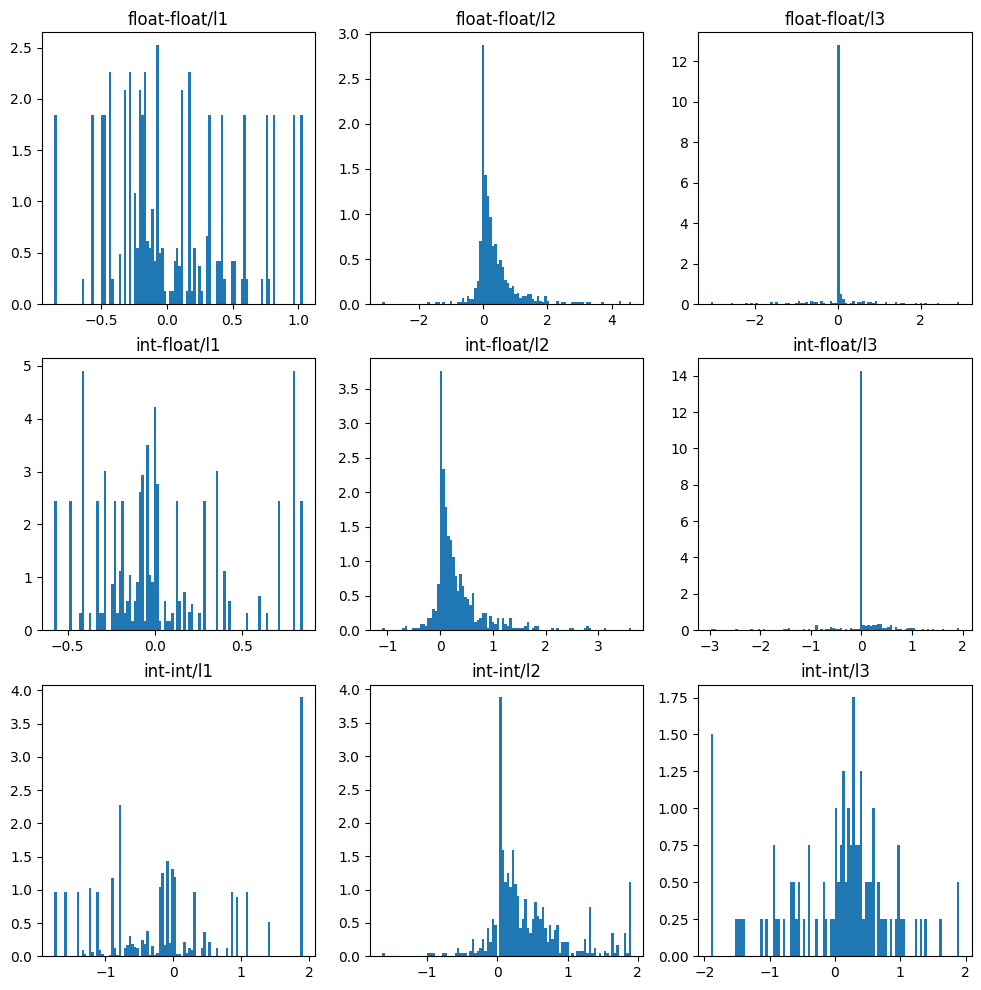

In [44]:
import matplotlib.pyplot as plt

def plot(ax, array, name):
    ax.set_title(name)
    array = array[array != 0]
    ax.hist(array.flatten(), bins=100, density=True)


fig, axes = plt.subplots(3, 3, figsize=(12, 12))

train_np(x, y)
for ax, layer in zip(axes[0], layers):
    plot(ax, layer.dw, "float-float/" + layer.name)
update_params(0)

train_ng_eval(x, y)
for ax, layer in zip(axes[1], layers):
    plot(ax, layer.dw, "int-float/" + layer.name)
update_params(0)

ng.backward([out_ng])
for ax, layer in zip(axes[2], layers):
    plot(ax, (layer.w_ng.grad / l.w_ng.grad_scale_factor), "int-int/" + layer.name)


In [46]:
train_np(x, y)
print(l3.dw)
update_params(0)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.26937953e-01  3.49740808e-05  5.97518862e-01  1.42167016e-05
   2.90868260e-02  1.95622848e-06  2.92151798e-05  7.39630576e-05
   1.69094218e-04  8.84546950e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

In [32]:
l1.dw.shape

(784, 100)

In [33]:
l1.w_ng.grad_scale_factor

122.99593933734664